# fine-tune on Bert

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm


In [2]:
# Load the training and testing datasets
train_essays = pd.read_csv("./llm-detect-ai-generated-text/train_essays.csv")
test_essays = pd.read_csv("./llm-detect-ai-generated-text/test_essays.csv")


In [3]:
# Explore the training data
train_essays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB


In [4]:
train_essays.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


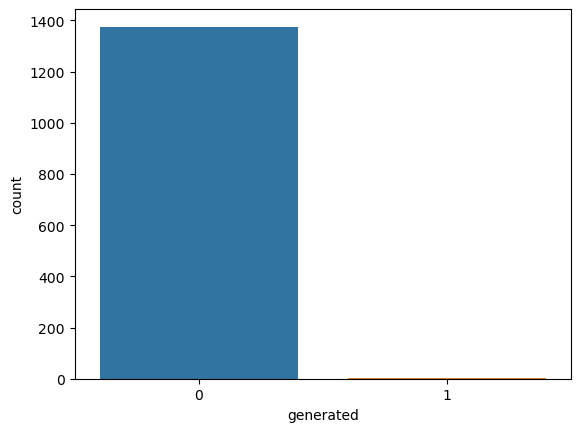

In [5]:
# Check for class balance
sns.countplot(data=train_essays, x='generated')
plt.show()


In [7]:
# Text Preprocessing
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuations
    words = text.split()  # Tokenize
    words = [word.lower() for word in words if word.isalpha()]  # Lowercase and remove non-alphabetic words
    words = [word for word in words if word not in stop_words]  # Remove stop words
    return ' '.join(words)

train_essays['clean_text'] = train_essays['text'].apply(clean_text)

In [8]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_essays['clean_text'], train_essays['generated'], test_size=0.2, random_state=42)


In [12]:
# Tokenization and Encoding for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, padding=True, truncation=True, max_length=128)
tokenizer.save_pretrained('./tokenizer/bert-base-uncased')

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: db5e15d5-b56e-4579-be76-13c627683453)')' thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt


('./tokenizer/bert-base-uncased/tokenizer_config.json',
 './tokenizer/bert-base-uncased/special_tokens_map.json',
 './tokenizer/bert-base-uncased/vocab.txt',
 './tokenizer/bert-base-uncased/added_tokens.json')

In [10]:
encoded_train = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors='pt')
encoded_val = tokenizer(X_val.tolist(), padding=True, truncation=True, return_tensors='pt')


In [11]:
# Convert labels to tensors
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)


In [12]:
# Create TensorDatasets
train_dataset = TensorDataset(encoded_train['input_ids'], encoded_train['attention_mask'], train_labels)
val_dataset = TensorDataset(encoded_val['input_ids'], encoded_val['attention_mask'], val_labels)


In [13]:
# DataLoader for efficient processing
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [8]:
# save the pretrained model to local so that I can use it without internet
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model.save_pretrained('./models/bert-base-uncased')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Define the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('./models/bert-base-uncased', num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [15]:
# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
epochs = 10

/Users/yuanlingzhi/anaconda3/envs/ml_zjb/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping to avoid exploding gradients
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss:.2f}")


100%|██████████| 69/69 [20:33<00:00, 17.87s/it]


Epoch 1/10, Average Training Loss: 0.01


100%|██████████| 69/69 [20:16<00:00, 17.63s/it]


Epoch 2/10, Average Training Loss: 0.01


100%|██████████| 69/69 [21:00<00:00, 18.26s/it]


Epoch 3/10, Average Training Loss: 0.00


100%|██████████| 69/69 [20:54<00:00, 18.18s/it]


Epoch 4/10, Average Training Loss: 0.04


100%|██████████| 69/69 [20:30<00:00, 17.83s/it]


Epoch 5/10, Average Training Loss: 0.01


100%|██████████| 69/69 [24:59<00:00, 21.74s/it]


Epoch 6/10, Average Training Loss: 0.01


100%|██████████| 69/69 [22:36<00:00, 19.66s/it]


Epoch 7/10, Average Training Loss: 0.00


100%|██████████| 69/69 [20:42<00:00, 18.01s/it]


Epoch 8/10, Average Training Loss: 0.00


100%|██████████| 69/69 [20:51<00:00, 18.14s/it]


Epoch 9/10, Average Training Loss: 0.00


100%|██████████| 69/69 [29:00<00:00, 25.23s/it]  

Epoch 10/10, Average Training Loss: 0.00


In [22]:
# Validation loop
model.eval()
val_preds = []
val_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        val_labels.extend(labels.cpu().numpy())


100%|██████████| 18/18 [01:16<00:00,  4.27s/it]


In [26]:
# Calculate validation accuracy
val_accuracy = accuracy_score(val_labels, val_preds)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Save the model
torch.save(model.state_dict(), 'bert_model.pt')

Validation Accuracy: 1.00


In [25]:
# Test data processing
test_inputs = tokenizer(test_essays['text'].tolist(), padding=True, truncation=True, return_tensors='pt')

# Move input tensor to the same device as the model
test_inputs = {key: value.to(device) for key, value in test_inputs.items()}

# Generate predictions using your trained model
with torch.no_grad():
    outputs = model(**test_inputs)
    logits = outputs.logits

# Assuming the first column of logits corresponds to the negative class (non-AI-generated) 
# and the second column corresponds to the positive class (AI-generated)
predictions = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()  # Move predictions back to CPU

# Create a submission DataFrame with essay IDs and corresponding predictions
submission = pd.DataFrame({
    'id': test_essays['id'],
    'generated': predictions
})

# Save the submission DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)
